# Download The Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/data/skin.zip', 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [ ]:
len(os.listdir('/data/IMG_CLASSES/1. Eczema 1677'))

1677

In [ ]:
data_dir = '/data/IMG_CLASSES'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['8. Seborrheic Keratoses and other Benign Tumors - 1.8k',
 '6. Benign Keratosis-like Lesions (BKL) 2624',
 '7. Psoriasis pictures Lichen Planus and related diseases - 2k',
 '1. Eczema 1677',
 '2. Melanoma 15.75k',
 '5. Melanocytic Nevi (NV) - 7970',
 '10. Warts Molluscum and other Viral Infections - 2103',
 '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k',
 '3. Atopic Dermatitis - 1.25k',
 '4. Basal Cell Carcinoma (BCC) 3323']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':' , len(os.listdir(data_dir + '/' + cls)))

8. Seborrheic Keratoses and other Benign Tumors - 1.8k : 1847
6. Benign Keratosis-like Lesions (BKL) 2624 : 2079
7. Psoriasis pictures Lichen Planus and related diseases - 2k : 2055
1. Eczema 1677 : 1677
2. Melanoma 15.75k : 3140
5. Melanocytic Nevi (NV) - 7970 : 7970
10. Warts Molluscum and other Viral Infections - 2103 : 2103
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k : 1702
3. Atopic Dermatitis - 1.25k : 1257
4. Basal Cell Carcinoma (BCC) 3323 : 3323


# Import the Dataset into PyTorch

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

27153

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=294x222 at 0x7FCC75144A90>, 0)

In [ ]:
dataset.classes

['1. Eczema 1677',
 '10. Warts Molluscum and other Viral Infections - 2103',
 '2. Melanoma 15.75k',
 '3. Atopic Dermatitis - 1.25k',
 '4. Basal Cell Carcinoma (BCC) 3323',
 '5. Melanocytic Nevi (NV) - 7970',
 '6. Benign Keratosis-like Lesions (BKL) 2624',
 '7. Psoriasis pictures Lichen Planus and related diseases - 2k',
 '8. Seborrheic Keratoses and other Benign Tumors - 1.8k',
 '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

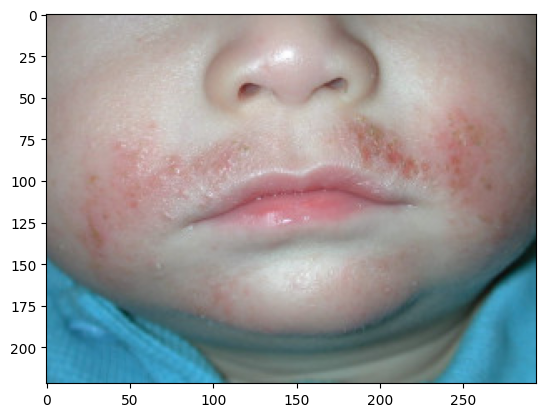

In [ ]:
img, label = dataset[0]
plt.imshow(img)

In [ ]:
#Image Reasizing
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose((tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor())))

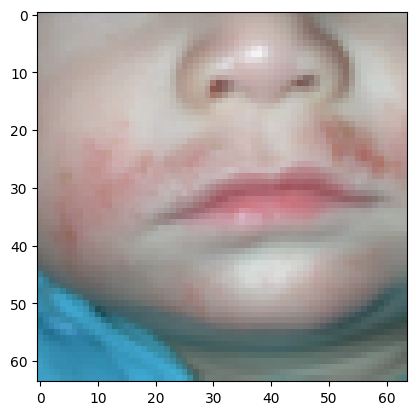

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
#Split the data for validation and training using random_split
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(24438, 2715)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(24438, 2715)

In [ ]:
#create data loaders for training and validation, to load the data in batches
from torch.utils.data.dataloader import DataLoader
batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2, 
                      pin_memory=True)

val_dl = DataLoader(valid_ds, 
                    batch_size*2, 
                    num_workers=2, 
                    pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

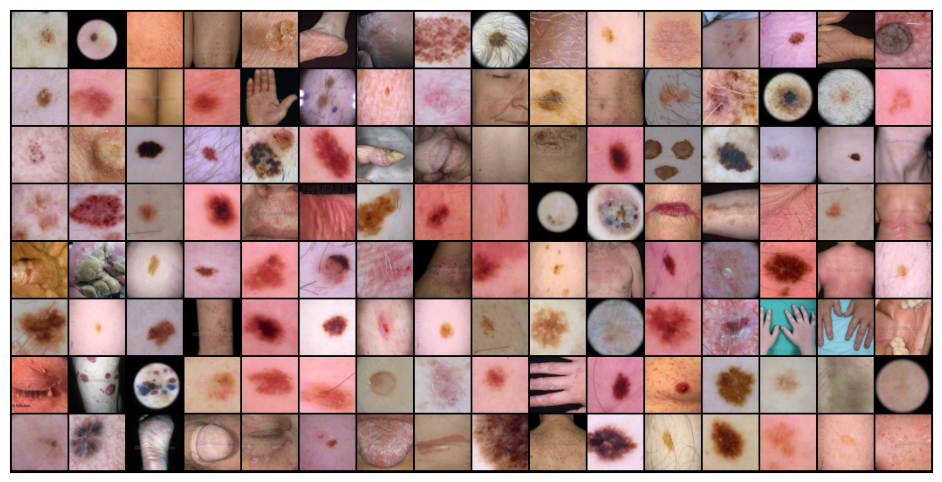

In [ ]:
show_batch(train_dl)

# Utility Functions and classes

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device
#cude is a language used to communicate with the GPU

device(type='cuda')

In [ ]:
img, label = dataset[0]
img.shape

torch.Size([3, 64, 64])

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

# Model and Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of training data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True)  # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512),  # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 2048
                                        nn.Dropout(0.2), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [ ]:
  torch.cuda.empty_cache()
  for batch in train_dl:
    images, labels = batch
    print('images.shape',images.shape)
    print('images.device',images.device)
    preds = model(images)
    print('preds.shape',preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 10])


# Training


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3116276264190674, 'val_acc': 0.06729976087808609}]

In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.SGD)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

# Test with individual images

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute((1, 2, 0)))
pred = predict_image(img, model, dataset.classes)
print('Target:',dataset.classes[label])
print('Prediction:', pred)

In [ ]:
def show_image_prediction(img, label):
  plt.imshow(img.permute((1, 2, 0)))
  pred = predict_image(img, model, dataset.classes)
  print('Target:',dataset.classes[label])
  print('Prediction:', pred)

In [ ]:
show_image_prediction(*valid_ds[2000])

In [ ]:
show_image_prediction(*valid_ds[100])

In [ ]:
show_image_prediction(*valid_ds[1000])

In [ ]:
show_image_prediction(*valid_ds[2300])

In [ ]:
show_image_prediction(*valid_ds[400])

In [ ]:
torch.save(model.state_dict(), 'skin_disease-resnet9.pth')

Transfer Learning


In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(dataset.classes), pretrained = True),device)

In [ ]:
model